In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


import numpy as np 
import pandas as pd



In [ ]:
Dataset = pd.read_csv("/content/drive/MyDrive/frames/6K - Sheet1.csv")    

In [ ]:
Dataset["label"] = Dataset["label"].astype(str)

In [ ]:
Dataset["name"] = Dataset["name"].astype(str)

In [ ]:
Dataset.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

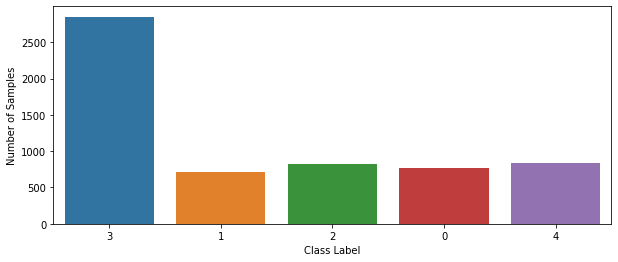

In [ ]:

fig, ax = plt.subplots(figsize = (10, 4))                                
sns.countplot(x ='label', data=Dataset)                                  
plt.xlabel("Class Label")                                                
plt.ylabel("Number of Samples")                                          
plt.show() 

## Splitting Data into Train/Test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
Data_train, Data_test = train_test_split(Dataset, test_size=0.2)                   

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)                            

In [ ]:
! unzip drive/MyDrive/frames/frames.zip

In [ ]:

dir1='/content/frames'

In [ ]:
train_gen=datagen.flow_from_dataframe(dataframe = Data_train,           
                                      directory=dir1,                   
                                      batch_size=30,                    
                                      class_mode="categorical",         
                                      x_col="name",                     
                                      color_mode="rgb",                 
                                      y_col="label",                    
                                      target_size=(224,224))            

Found 4800 validated image filenames belonging to 5 classes.


## Creating Validation Data

In [ ]:
valid_gen=datagen.flow_from_dataframe(dataframe = Data_test,            
                                      directory=dir1,                  
                                      batch_size=30,                    
                                      class_mode="categorical",        
                                      x_col="name",                     
                                      color_mode="rgb",                
                                      y_col="label",                    
                                      target_size=(224,224))           

Found 1200 validated image filenames belonging to 5 classes.


In [ ]:
import keras
from tensorflow.keras import applications

In [ ]:
ResNet_model = keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

234545216/234545216 [==============================] - 12s 0us/step


## Building Model

In [ ]:
from keras import Model 
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from keras.models import Sequential

In [ ]:
for layer in ResNet_model.layers[:-15]:       
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=5, activation='softmax')(x)
model = Model(ResNet_model.input, output)

In [ ]:
print(model.summary())

### Setting Loss function, Optimizer and Compling the model

In [ ]:
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

### Compiling the Model

In [ ]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

160
40


In [ ]:
transfer_learning_history = model.fit_generator(generator=train_gen,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data=valid_gen,
                            validation_steps=STEP_SIZE_VALID,
                            epochs=5)

<ipython-input-36-683ada8cab79>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_history = model.fit_generator(generator=train_gen,


Epoch 1/5
160/160 [==============================] - 95s 546ms/step - loss: 0.0233 - accuracy: 0.9921 - val_loss: 3.4202 - val_accuracy: 0.6317
Epoch 2/5
160/160 [==============================] - 83s 520ms/step - loss: 0.0208 - accuracy: 0.9919 - val_loss: 3.4820 - val_accuracy: 0.6350
Epoch 3/5
160/160 [==============================] - 84s 526ms/step - loss: 0.0189 - accuracy: 0.9931 - val_loss: 3.5442 - val_accuracy: 0.6383
Epoch 4/5
160/160 [==============================] - 83s 521ms/step - loss: 0.0182 - accuracy: 0.9944 - val_loss: 3.4894 - val_accuracy: 0.6442
Epoch 5/5
160/160 [==============================] - 83s 520ms/step - loss: 0.0202 - accuracy: 0.9935 - val_loss: 3.5262 - val_accuracy: 0.6333


## Visualizing accuracy and loss

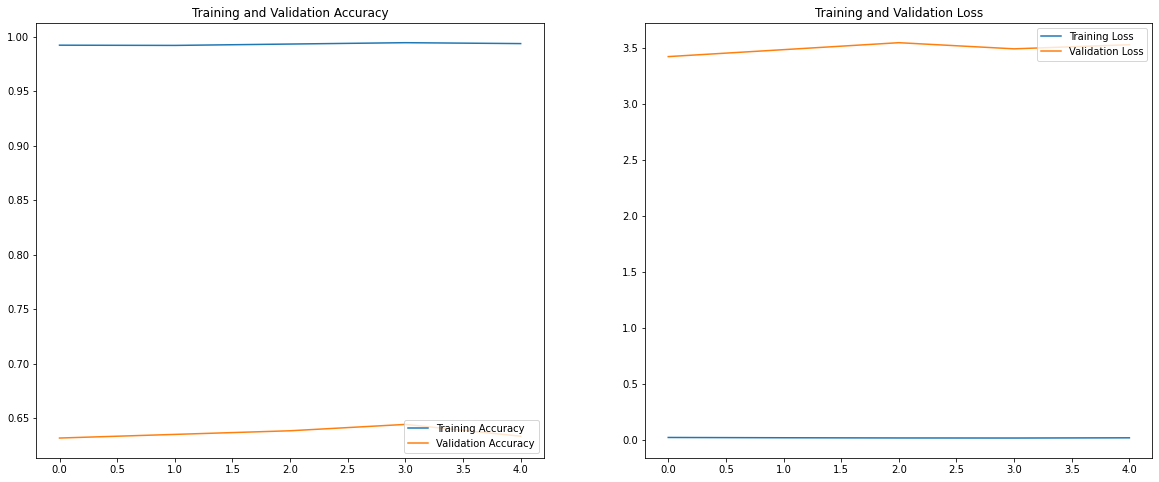

In [ ]:
import matplotlib.pyplot as plt

acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()